In [1]:
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import math

spark = SparkSession.builder.appName("Stress Levels Analysis").getOrCreate()
sc = spark.sparkContext

In [12]:
from threading import Thread
from queue import Queue

Q = Queue()
def log_func(x):
    return math.log(x+1)

def log_scale_func(x, scale):
    return math.log((x+1) * scale)

def map_func(train_df, func, column):
    column_out = train_df.select(column).rdd.map(lambda x: func(x[0])).collect()

    Q.put((column, column_out))

In [13]:
# read dataset for data cleaning and pre processing
train_df = spark.read.csv("../dataset/train_combined.csv", header=True, inferSchema=True)
test_df = spark.read.csv("../dataset/test_combined.csv", header=True, inferSchema=True)

In [14]:
log_columns = [    
    "SDRR_REL_RR",
    "LF_HF",
    "SKEW",
    "KURT",
    "sampen",
]
log_scale_columns = [
    "MEAN_REL_RR",
    "MEDIAN_REL_RR",
]

threads = { column: Thread(target=lambda: map_func(train_df, log_func, column)) for column in log_columns }
threads.update({ column: Thread(target=lambda: map_func(train_df, lambda x: log_scale_func(x, 100), column)) for column in log_scale_columns })

for column, thread in threads.items():
    thread.start()

for column, thread in threads.items():
    thread.join()

# reduce function
# for 


In [16]:
for i in range(Q.qsize()):
    column, column_out = Q.get()
    train_df = train_df.withColumn(column, F.array(*[F.lit(x) for x in column_out]))

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "C:\Users\sicom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\py4j\clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\sicom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "C:\Users\sicom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\py4j\clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkEr

Py4JError: org.apache.spark.sql.functions.lit does not exist in the JVM

In [7]:
log_columns = [    
    "SDRR_REL_RR",
    "LF_HF",
    "SKEW",
    "KURT",
    "sampen",
]


for column in log_columns:
    min_val_train = train_df.select(F.min(F.col(column))).collect()[0][0]
    min_val_test = test_df.select(F.min(F.col(column))).collect()[0][0]
    min_val = min(min_val_train, min_val_test)

    train_df = train_df.withColumn(column, F.log1p(F.col(column) - min_val))
    test_df = test_df.withColumn(column, F.log1p(F.col(column) - min_val))

log_scale_columns = [
    "MEAN_REL_RR",
    "MEDIAN_REL_RR",
]
for column in log_scale_columns:
    min_val_train = train_df.select(F.min(F.col(column))).collect()[0][0]
    min_val_test = test_df.select(F.min(F.col(column))).collect()[0][0]
    min_val = min(min_val_train, min_val_test)

    train_df = train_df.withColumn(column, F.log1p((F.col(column) - min_val) * 1000))
    test_df = test_df.withColumn(column, F.log1p((F.col(column) - min_val) * 1000))


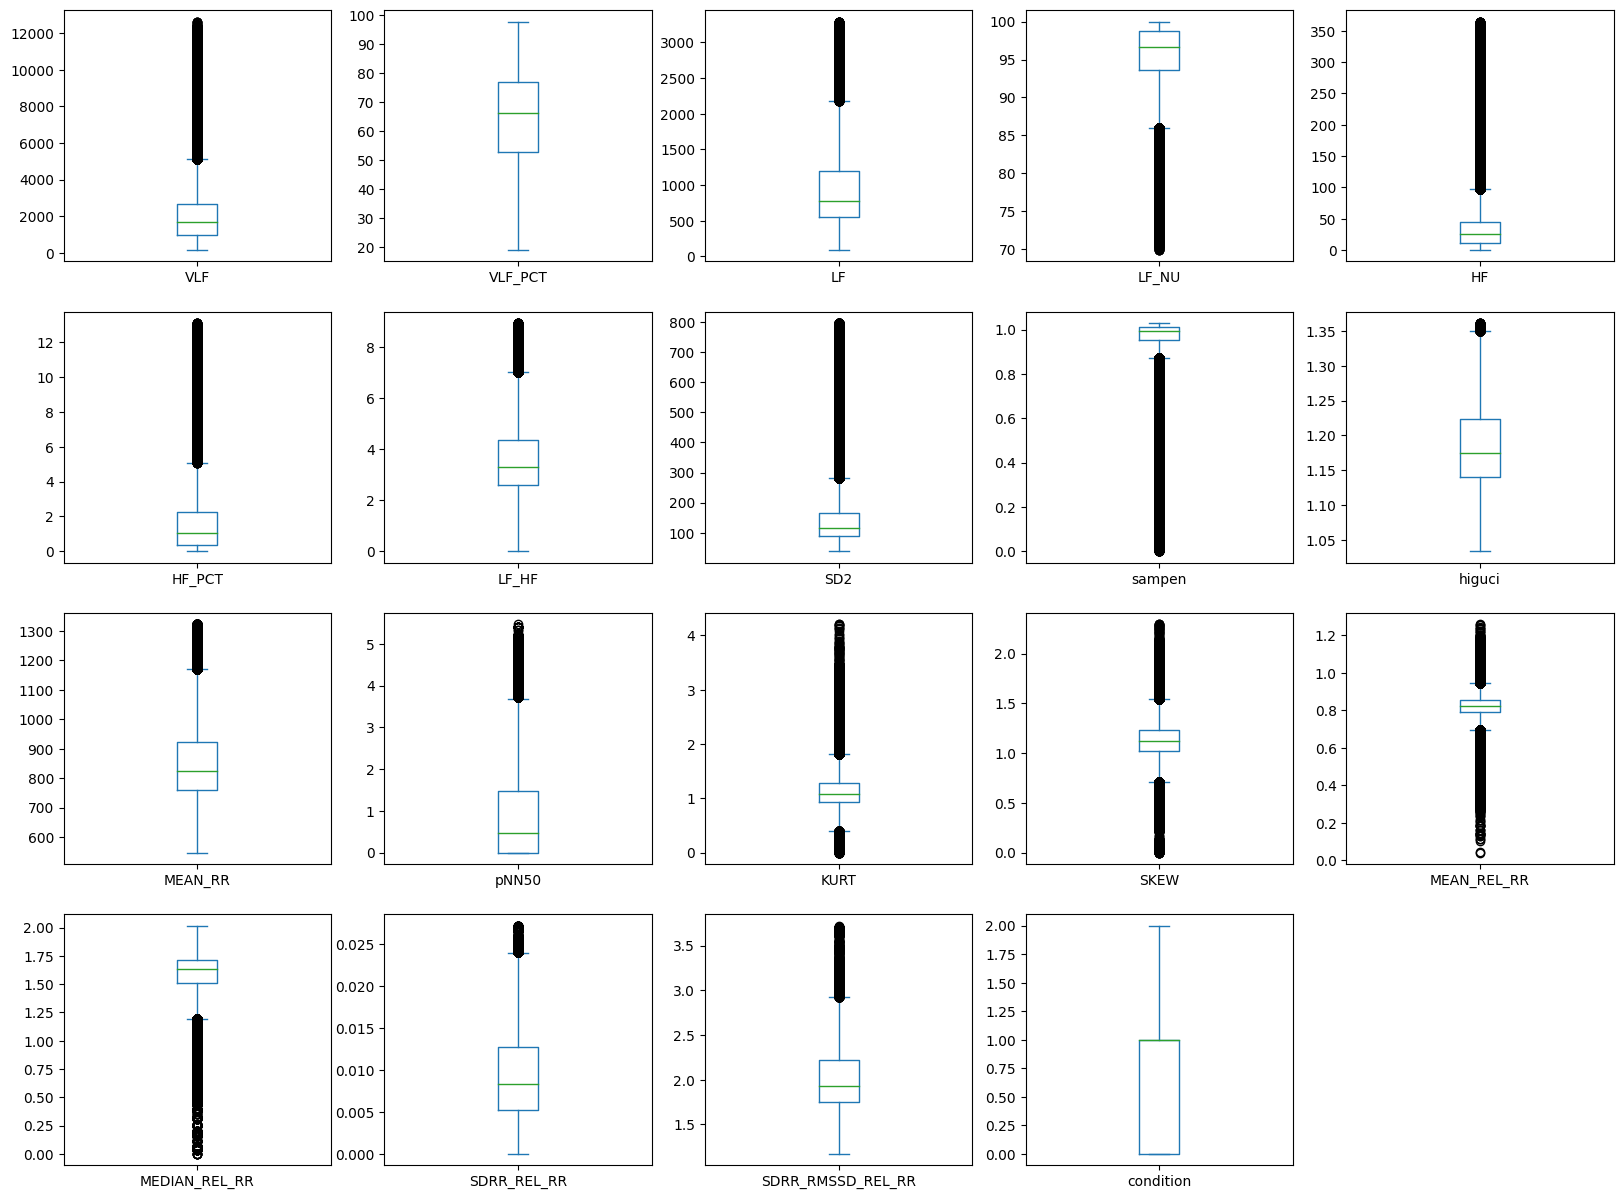

In [8]:
# show boxplots of the new dataframe
train_log_df = train_df.toPandas()
train_log_df.plot(kind='box', subplots=True, layout=(4, 5), figsize=(20, 15))
plt.show()

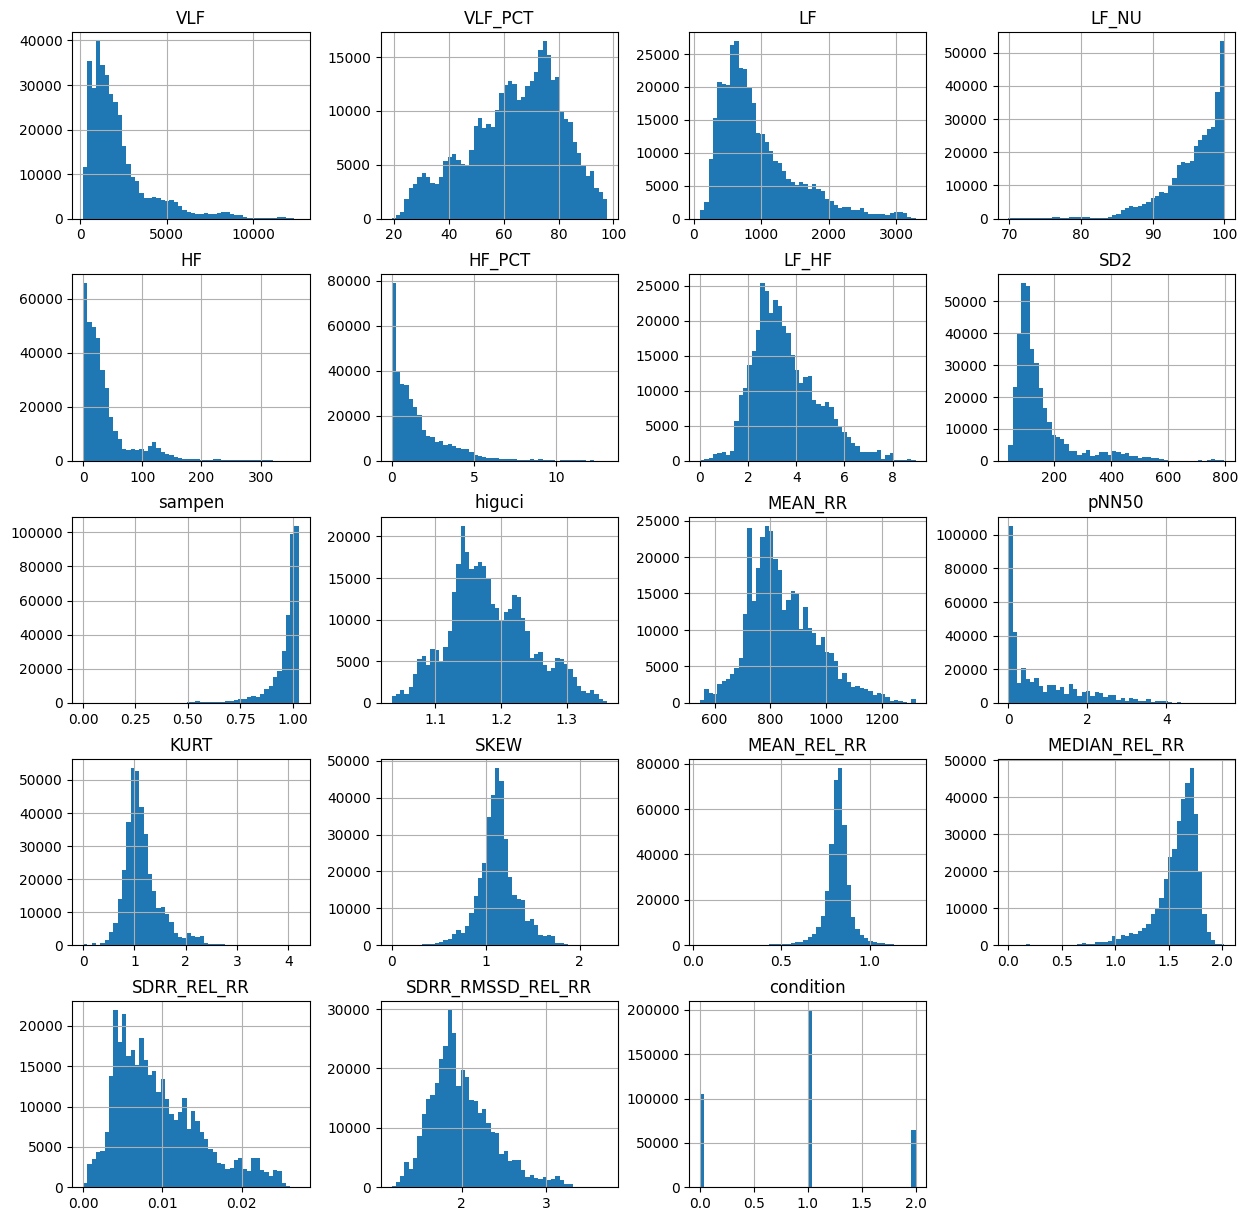

In [9]:
train_log_df.hist(bins=50, figsize=(15, 15))
plt.show()

In [12]:
# write data to csv
train_df.toPandas().to_csv("../dataset/train_preprocessed.csv", index=False)
test_df.toPandas().to_csv("../dataset/test_preprocessed.csv", index=False)